[Epoch 1/50] [D loss: 0.1236] [G loss: 6.0169]


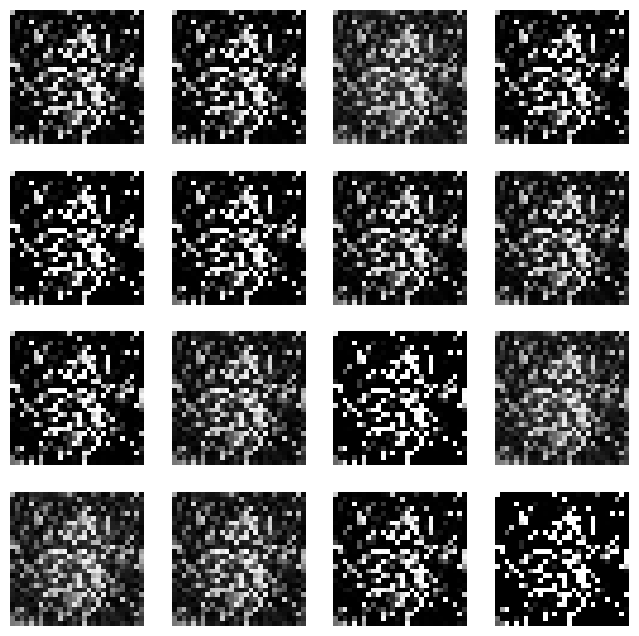

[Epoch 2/50] [D loss: 1.0276] [G loss: 2.1110]
[Epoch 3/50] [D loss: 0.6959] [G loss: 1.0561]
[Epoch 4/50] [D loss: 0.2737] [G loss: 2.3818]
[Epoch 5/50] [D loss: 0.3350] [G loss: 2.6679]
[Epoch 6/50] [D loss: 0.2507] [G loss: 2.2048]
[Epoch 7/50] [D loss: 0.6067] [G loss: 3.0916]
[Epoch 8/50] [D loss: 0.3208] [G loss: 2.6942]
[Epoch 9/50] [D loss: 0.4262] [G loss: 1.8801]
[Epoch 10/50] [D loss: 0.2373] [G loss: 5.1771]
[Epoch 11/50] [D loss: 0.1668] [G loss: 4.9798]


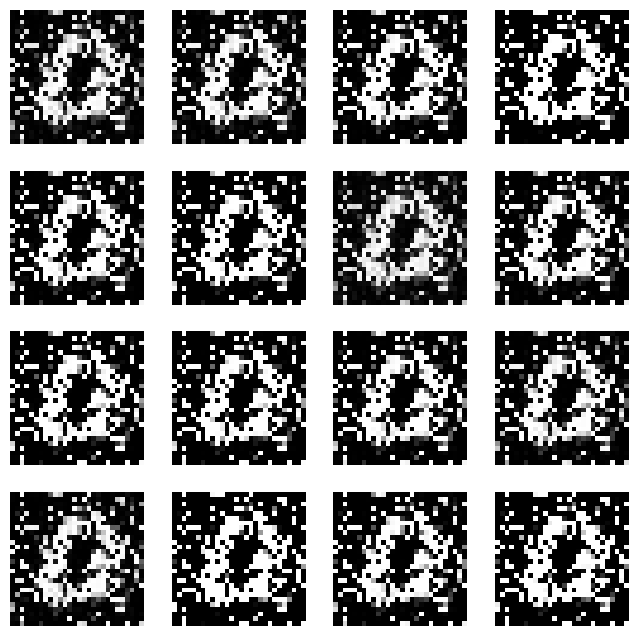

[Epoch 12/50] [D loss: 0.1687] [G loss: 8.4322]
[Epoch 13/50] [D loss: 0.0410] [G loss: 5.9616]
[Epoch 14/50] [D loss: 0.1172] [G loss: 8.0571]
[Epoch 15/50] [D loss: 0.0496] [G loss: 5.8369]
[Epoch 16/50] [D loss: 0.0626] [G loss: 6.1749]
[Epoch 17/50] [D loss: 0.1168] [G loss: 6.4617]
[Epoch 18/50] [D loss: 0.1597] [G loss: 4.1321]
[Epoch 19/50] [D loss: 0.1421] [G loss: 6.1798]
[Epoch 20/50] [D loss: 0.1624] [G loss: 3.8700]


KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 生成器模型
class Generator(nn.Module):
    def __init__(self, latent_dim, img_size):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, img_size),
            nn.Tanh()  # 输出在 [-1, 1] 之间
        )

    def forward(self, z):
        img = self.fc(z)
        img = img.view(img.size(0), 1, 28, 28)  # Reshape to image dimensions
        return img

# 判别器模型
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(img_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # 输出为 [0, 1] 概率
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # 展平图像
        validity = self.fc(img_flat)
        return validity

# 数据转换
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # 将数据归一化到 [-1, 1] 范围
])

# 下载和加载 MNIST 数据集
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# 超参数
latent_dim = 100  # 噪声向量的维度
img_size = 28 * 28  # MNIST 图片尺寸 (28x28)
lr = 0.0002  # 学习率
num_epochs = 50  # 训练轮数

# 初始化生成器和判别器
generator = Generator(latent_dim, img_size)
discriminator = Discriminator(img_size)

# 损失函数和优化器
adversarial_loss = nn.BCELoss()  # 二元交叉熵损失
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# 训练GAN
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(trainloader):

        # ---------------------
        # 训练判别器
        # ---------------------

        # 真实图像标签为1，生成图像标签为0
        valid = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)

        # 真实图像
        real_imgs = imgs.view(imgs.size(0), -1)

        # 生成随机噪声
        z = torch.randn(imgs.size(0), latent_dim)

        # 生成假图像
        gen_imgs = generator(z)

        # 计算判别器损失
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 反向传播更新判别器权重
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        # 训练生成器
        # ---------------------

        # 生成图像的标签期望为真实标签，即1
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        # 反向传播更新生成器权重
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"[Epoch {epoch+1}/{num_epochs}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    # 每隔几轮可视化生成的图像
    if epoch % 10 == 0:
        with torch.no_grad():
            z = torch.randn(64, latent_dim)
            gen_imgs = generator(z).view(-1, 1, 28, 28).cpu().numpy()
            gen_imgs = 0.5 * gen_imgs + 0.5  # 恢复到 [0, 1] 区间
            plt.figure(figsize=(8, 8))
            for i in range(16):
                plt.subplot(4, 4, i + 1)
                plt.imshow(gen_imgs[i][0], cmap='gray')
                plt.axis('off')
            plt.show()
